In [14]:
import pandas as pd
import csv
import numpy as np
from umap.umap_ import UMAP
import sklearn
from sklearn.manifold import Isomap
import kmapper as km
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

from scipy.stats import zscore
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import json

import sys
from pathlib import Path

In [2]:
# Add the project directory to sys.path

project_root = Path.cwd().parent
project_dir = str(project_root)
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [3]:
from tda_genes_alzheimers.my_support_functions import *
from tda_genes_alzheimers.config import gene_expression_data_path, gene_meta_data_path, intermediate_data_dir

# 0. Import

In [4]:
# gene metadata
F_gene_meta_df = pd.read_csv(gene_meta_data_path, sep='\t', comment='^', skiprows=27, low_memory=False) 
F_gene_meta_df = F_gene_meta_df.drop(F_gene_meta_df.index[-1])      # delete end of table row

# gene expression data
with open(gene_expression_data_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    GSE44772_list_data = list(reader)                                               # list to export meta_data
GSE44772_df = pd.read_csv(gene_expression_data_path, comment='!', sep ='\t')        # data frame for analysis
# subject meta
metadata_df = extract_metadata_GSE44772(GSE44772_list_data)
metadata_df = metadata_df[:-1]
num_metadata_df, category_mapping = convert_meta_to_numeric(metadata_df)
metadata_sorted_df = metadata_df.sort_values(by=['Disease'])    
num_metadata_sorted_df = num_metadata_df.sort_values(by=['Disease'])   

In [5]:
#load
path_to_load = intermediate_data_dir / 'preprocessed'
preprocessed_df = pd.read_csv(path_to_load/'pp_GSE44772.csv', sep='\t')
preprocessed_gene_meta_df = pd.read_csv(path_to_load/'pp_GSE44772_genes.csv', sep='\t') 

In [6]:
# sort to make things easier in the future
preprocessed_df.sort_values(by=['ID_REF'], inplace=True)
preprocessed_gene_meta_df.sort_values(by=['ID_REF'], inplace=True)
preprocessed_gene_meta_df.reset_index(drop=True, inplace=True)

# 1. Preprocess

Get absolute values correlations

In [7]:
# DLPFC
corr_H_DLPFC = get_correlation_for_group_BR(metadata_sorted_df, preprocessed_df, 'N', 'DLPFC')
corr_A_DLPFC = get_correlation_for_group_BR(metadata_sorted_df, preprocessed_df, 'A', 'DLPFC')

# Get absolute value of correlation matrices
abs_corr_H_DLPFC = np.abs(corr_H_DLPFC)
abs_corr_A_DLPFC = np.abs(corr_A_DLPFC)

Generate Mapper graphs

In [8]:
path_to_saved_maps = intermediate_data_dir / 'maps' / 'genes' /'BR_GO'      # Brain Region GO folder

# initialize mapper
mapper = km.KeplerMapper(verbose=1)
# mapper parameters 
BR_projection = [Isomap(n_components=100, n_jobs=-1), UMAP(n_components=2, random_state=1)]

# get gene symbols do display on mapper visualization (instead of gene IDs)
filtered_symbols_arr = get_gene_symbols_for_viz(F_gene_meta_df, preprocessed_gene_meta_df)

# intialize Vietoris Rips for PD
VR = VietorisRipsPersistence(homology_dimensions=[0, 1])

KeplerMapper(verbose=1)


In [9]:
%%capture

# H
projected_H_DLPFC =  mapper.fit_transform(abs_corr_H_DLPFC, projection=BR_projection)
Graph_H_DLPFC = mapper.map(lens=projected_H_DLPFC, X=abs_corr_H_DLPFC,
                    clusterer=sklearn.cluster.DBSCAN(metric="cosine"),
                    cover = km.Cover(n_cubes=85, perc_overlap=0.59))

# # A
projected_A_DLPFC =  mapper.fit_transform(abs_corr_A_DLPFC, projection=BR_projection)
Graph_A_DLPFC = mapper.map(lens=projected_A_DLPFC, X=abs_corr_A_DLPFC,
                    clusterer=sklearn.cluster.DBSCAN(metric="cosine"),
                    cover = km.Cover(n_cubes=85, perc_overlap=0.6))

# extracts DBSCAN colors (only for Healthy)
labels_DLPFC, colorscale_DLPFC = get_cluster_labels_and_colorscale_GSE33000(Graph_H_DLPFC, corr_H_DLPFC)


# 2. Go enrichment analysis

## 2.1. Extrach 20% of most variable Mapper nodes and their corresponding genes

In [10]:
print(Graph_A_DLPFC.keys())

dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes'])


In [11]:
Graph_A_DLPFC['nodes']['cube575_cluster0']

[355, 479, 3000, 3904, 4235, 5673, 5892, 6116]

In [62]:
for key, value in Graph_A_DLPFC.items():
    print(f"Key: {key} -> Value: {value}")


Key: nodes -> Value: defaultdict(<class 'list'>, {'cube2_cluster0': [1099, 1182, 3214, 3376, 3936, 4805, 5053, 5146, 5823, 6119, 6137, 6232], 'cube3_cluster0': [1099, 3376, 3936, 4668, 4805, 5053, 5146, 5812, 5823, 5924, 6022, 6119, 6137, 6232], 'cube4_cluster0': [110, 3936, 4539, 4668, 4805, 5812, 5924, 6022, 6137, 6171, 6232, 6357], 'cube5_cluster0': [110, 3624, 4446, 4539, 4668, 5091, 5807, 5812, 6171, 6357], 'cube6_cluster0': [3624, 4446, 4539, 5091, 5807, 6171, 6357], 'cube9_cluster0': [1182, 1523, 2499, 3214, 6119], 'cube10_cluster0': [1099, 1182, 1523, 2499, 3214, 5053, 5146, 5823, 6119, 6232], 'cube11_cluster0': [1099, 1523, 4668, 5053, 5146, 5812, 5823, 6022, 6119, 6232], 'cube12_cluster0': [110, 1484, 2026, 3566, 4539, 4668, 4827, 5812, 6022, 6096, 6171, 6232, 6357], 'cube13_cluster0': [110, 1484, 2026, 3566, 3624, 3727, 3793, 4279, 4446, 4539, 4668, 4827, 5091, 5706, 5807, 5812, 6096, 6171, 6357], 'cube14_cluster0': [1484, 2026, 3566, 3624, 3727, 3793, 4279, 4446, 4539, 5091

In [63]:
for node_id, data_indices in Graph_A_DLPFC['nodes'].items():
    print(node_id, data_indices)

cube2_cluster0 [1099, 1182, 3214, 3376, 3936, 4805, 5053, 5146, 5823, 6119, 6137, 6232]
cube3_cluster0 [1099, 3376, 3936, 4668, 4805, 5053, 5146, 5812, 5823, 5924, 6022, 6119, 6137, 6232]
cube4_cluster0 [110, 3936, 4539, 4668, 4805, 5812, 5924, 6022, 6137, 6171, 6232, 6357]
cube5_cluster0 [110, 3624, 4446, 4539, 4668, 5091, 5807, 5812, 6171, 6357]
cube6_cluster0 [3624, 4446, 4539, 5091, 5807, 6171, 6357]
cube9_cluster0 [1182, 1523, 2499, 3214, 6119]
cube10_cluster0 [1099, 1182, 1523, 2499, 3214, 5053, 5146, 5823, 6119, 6232]
cube11_cluster0 [1099, 1523, 4668, 5053, 5146, 5812, 5823, 6022, 6119, 6232]
cube12_cluster0 [110, 1484, 2026, 3566, 4539, 4668, 4827, 5812, 6022, 6096, 6171, 6232, 6357]
cube13_cluster0 [110, 1484, 2026, 3566, 3624, 3727, 3793, 4279, 4446, 4539, 4668, 4827, 5091, 5706, 5807, 5812, 6096, 6171, 6357]
cube14_cluster0 [1484, 2026, 3566, 3624, 3727, 3793, 4279, 4446, 4539, 5091, 5706, 5807, 6171, 6357]
cube16_cluster0 [1070, 2120, 2938, 3350, 3402, 4198, 4310, 4407, 54

In [12]:
aggregation_functions = {
    "mean": np.mean,
    "max": np.max,
    "std": np.std,
    "median": np.median
}

# Prepare a DataFrame to store the node color results
node_color_data = []

# Iterate through each node in the graph
for node_id, data_indices in Graph_A_DLPFC['nodes'].items():
    # Extract the 'DBSCAN' values for the data points in this node
    node_values = labels_DLPFC[data_indices]


    # Calculate the node colors based on aggregation functions
    node_colors = {func_name: func(node_values) for func_name, func in aggregation_functions.items()}
    
    # Add node ID and calculated colors to the result
    node_colors['Node ID'] = node_id
    node_colors['Gene ID'] = data_indices
    node_color_data.append(node_colors)

# Create a DataFrame with the node color results
node_color_df = pd.DataFrame(node_color_data)

# Convert the index into a column
node_color_df.reset_index(inplace=True)

# Rename the new column from 'index' to 'Label'
node_color_df.rename(columns={'index': 'Label'}, inplace=True)


In [15]:

def extract_node_color_metrics(file_path):
    # Read HTML content
    with open(file_path, 'r', encoding='utf-8') as f:
        html_content = f.read()
    
    # Find JSON-like structure within the HTML (assuming 'const graph = { ... };' pattern)
    match = re.search(r'const graph = (\{.*?\});', html_content, re.DOTALL)
    if not match:
        raise ValueError("Graph data structure not found in the HTML file.")
    
    # Extract JSON data portion and clean it up
    graph_data_str = match.group(1).rstrip(";")
    
    # Load JSON safely by parsing only the JSON content
    try:
        graph_data = json.loads(graph_data_str)
    except json.JSONDecodeError as e:
        raise ValueError(f"Failed to parse JSON data: {e}")
    
    # Initialize lists for each metric
    means, maxs, stds, medians = [], [], [], []
    
    # Extract colors and metrics from nodes
    for node in graph_data.get("nodes", []):
        colors = node.get("color", [0, 0, 0, 0])
        if len(colors) < 4:
            raise ValueError("Node color array is not of length 4")
        
        # Append each metric to its corresponding list
        means.append(colors[0])
        maxs.append(colors[1])
        stds.append(colors[2])
        medians.append(colors[3])
    
    # Convert lists to numpy arrays
    means = np.array(means)
    maxs = np.array(maxs)
    stds = np.array(stds)
    medians = np.array(medians)
    
    return means, maxs, stds, medians


means, maxs, stds, medians = extract_node_color_metrics('/Users/ayasamadzelkava/Projects/vscode/TDA_genes_Alzheimers/data/intermediate/maps/genes/corr/map_genes_PC_A_DLPFC.html')

In [65]:
# Calculate the threshold for the top 20% of 'std' values
threshold = node_color_df['std'].quantile(0.80)

# Filter the DataFrame to get only the rows with 'std' values in the top 20%
top_20_percent_std_df = node_color_df[node_color_df['std'] >= threshold]


In [66]:
# Flatten the list of lists and count unique genes
unique_genes = set(gene for sublist in top_20_percent_std_df['Gene ID'] for gene in sublist)
unique_genes_count = len(unique_genes)

print(f"Number of unique genes: {unique_genes_count}")

Number of unique genes: 2265


In [67]:
# extract go: biological process, molecular function, cell component
go_bp, go_mf, go_cc = extract_go_terms(gene_meta_data_path)

In [68]:
pp_bp_df = get_go_for_existing_genes(preprocessed_gene_meta_df, 'GO:Process', F_gene_meta_df)

In [69]:
unique_genes_std_bp = pd.DataFrame(unique_genes)

In [70]:
genes_of_interest = preprocessed_gene_meta_df.loc[list(unique_genes), 'Gene symbol'].tolist()

In [71]:
import gseapy as gp
import pandas as pd

# Assume df has your gene data and has been loaded into a DataFrame.
#genes_of_interest = list(unique_genes)  # List of unique genes you want to analyze

# Run GO Enrichment Analysis
enrichment_results = gp.enrichr(
    gene_list=genes_of_interest,
    gene_sets='GO_Biological_Process_2021',  # You can specify BP, MF, or CC sets here
    organism="h. sapiens",  # Use 'hsapiens' for human, 'mmusculus' for mouse, etc.
    outdir=None  # Set to None to prevent saving files
)

# Convert results to a DataFrame for easy handling and display
enriched_go_terms = enrichment_results.results
enriched_go_terms_df = pd.DataFrame(enriched_go_terms)

# Display the enriched terms
enriched_go_terms_df[['Term', 'P-value', 'Adjusted P-value', 'Odds Ratio', 'Combined Score']].head()


,Term,P-value,Adjusted P-value,Odds Ratio,Combined Score
0,vascular associated smooth muscle cell develop...,0.000013,0.061774,47.102258,528.997601
1,cytoskeleton-dependent intracellular transport...,0.000096,0.224529,6.045369,55.902500
2,cell-cell junction assembly (GO:0007043),0.000285,0.230948,2.951769,24.098371
3,protein localization to cell periphery (GO:199...,0.000411,0.230948,2.150702,16.767338
4,positive regulation of transmembrane receptor ...,0.000492,0.230948,2.475193,18.855141


In [72]:
# Filter for significant GO terms (e.g., adjusted p-value < 0.05)
significant_terms = enriched_go_terms_df[enriched_go_terms_df['P-value'] < 0.05]
significant_terms[['Term', 'Adjusted P-value', 'Combined Score']].head()


,Term,Adjusted P-value,Combined Score
0,vascular associated smooth muscle cell develop...,0.061774,528.997601
1,cytoskeleton-dependent intracellular transport...,0.224529,55.902500
2,cell-cell junction assembly (GO:0007043),0.230948,24.098371
3,protein localization to cell periphery (GO:199...,0.230948,16.767338
4,positive regulation of transmembrane receptor ...,0.230948,18.855141


## 2.2. Bar plot

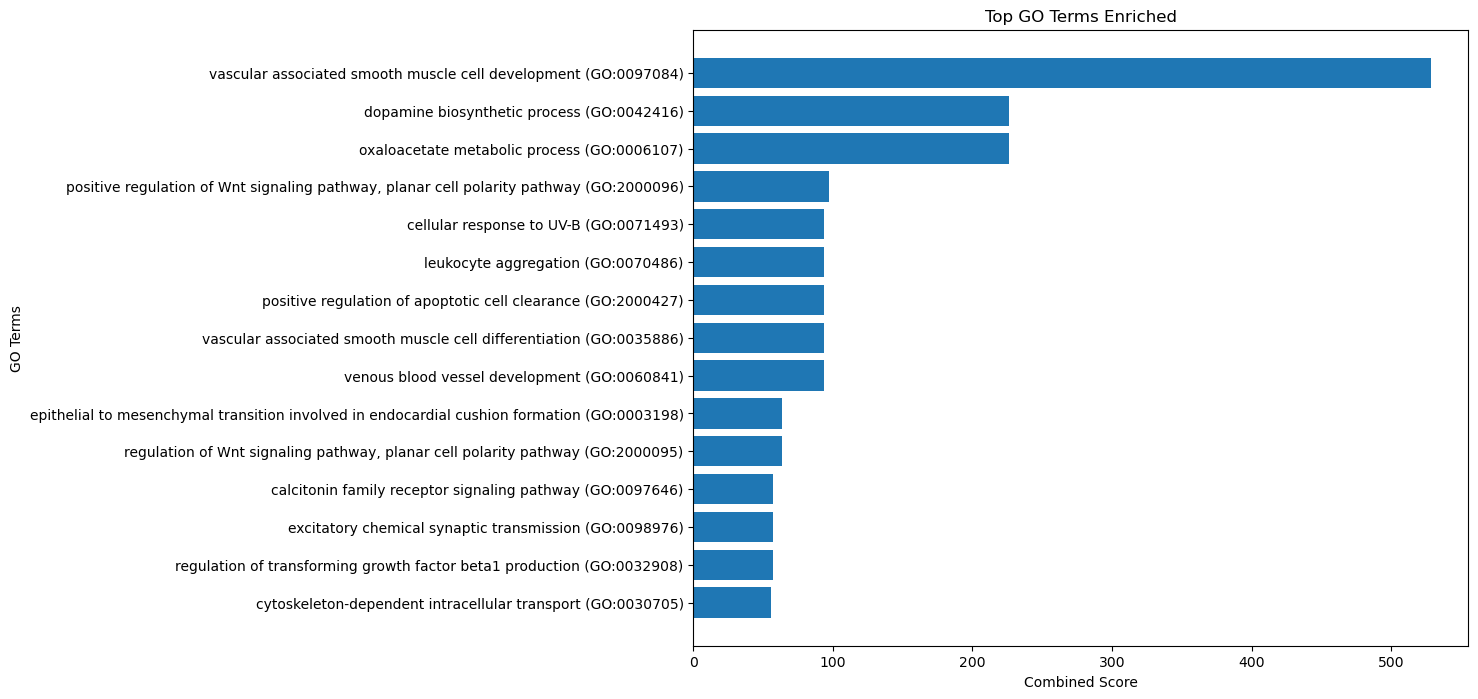

In [158]:
import matplotlib.pyplot as plt

# Select top enriched terms based on adjusted p-value
top_terms = significant_terms.nlargest(15, 'Combined Score')

plt.figure(figsize=(10, 8))
plt.barh(top_terms['Term'], top_terms['Combined Score'])
plt.xlabel('Combined Score')
plt.ylabel('GO Terms')
plt.title('Top GO Terms Enriched')
plt.gca().invert_yaxis()  # Highest scores at the top
plt.show()


In [24]:
top_terms

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,vascular associated smooth muscle cell develop...,6/7,0.000013,0.061774,0,0,47.102258,528.997601,EFEMP2;RAMP2;NOTCH1;HEY2;HES1;ENG
8,GO_Biological_Process_2021,dopamine biosynthetic process (GO:0042416),4/5,0.000746,0.230948,0,0,31.373728,225.902842,TGFB2;DAO;GCH1;SNCA
9,GO_Biological_Process_2021,oxaloacetate metabolic process (GO:0006107),4/5,0.000746,0.230948,0,0,31.373728,225.902842,MDH1;PCK1;NIT2;MDH1B
22,GO_Biological_Process_2021,"positive regulation of Wnt signaling pathway, ...",4/6,0.002037,0.411961,0,0,15.685980,97.193002,DAB2;RSPO3;PLEKHA4;NKD1
10,GO_Biological_Process_2021,cellular response to UV-B (GO:0071493),5/8,0.000773,0.230948,0,0,13.076696,93.697643,CDKN1A;STK11;MME;HYAL3;CRIP1
11,GO_Biological_Process_2021,leukocyte aggregation (GO:0070486),5/8,0.000773,0.230948,0,0,13.076696,93.697643,SEMA4D;BMP7;S100A9;CD44;S100A8
12,GO_Biological_Process_2021,positive regulation of apoptotic cell clearanc...,5/8,0.000773,0.230948,0,0,13.076696,93.697643,C4B;C4A;CCL2;ABCA7;CD300LF
13,GO_Biological_Process_2021,vascular associated smooth muscle cell differe...,5/8,0.000773,0.230948,0,0,13.076696,93.697643,EFEMP2;RAMP2;HEY2;HES1;ENG
14,GO_Biological_Process_2021,venous blood vessel development (GO:0060841),5/8,0.000773,0.230948,0,0,13.076696,93.697643,ACVRL1;BMPR2;FOXF1;PROX1;ENG
19,GO_Biological_Process_2021,epithelial to mesenchymal transition involved ...,5/9,0.001577,0.349846,0,0,9.806969,63.277480,HEYL;NOTCH1;HEY2;SNAI1;ENG


## 2.3. Dendrogram

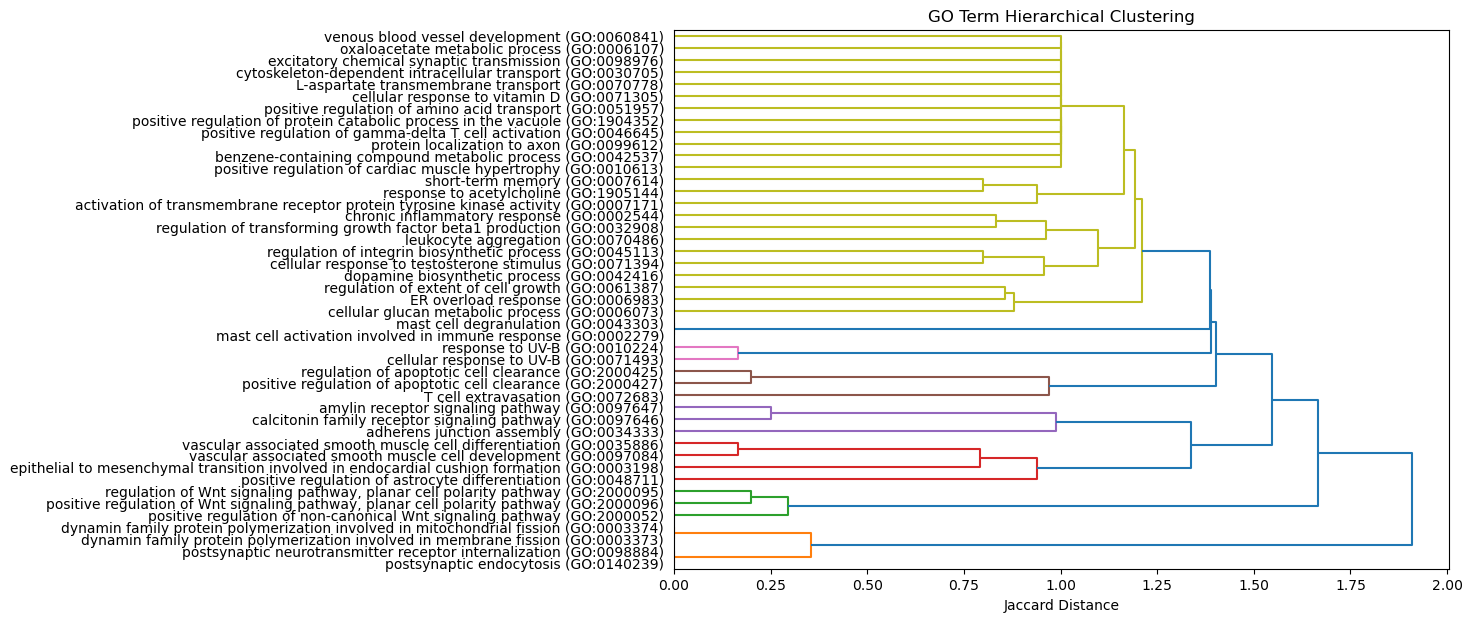

In [50]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

terms_to_dendrogram = top_terms

terms_to_dendrogram['Genes'] = terms_to_dendrogram['Genes'].apply(lambda x: set(x.split(';')))
# Get a list of all unique genes across all GO terms
all_genes = sorted(set.union(*terms_to_dendrogram['Genes']))

# Create a binary matrix where rows are GO terms and columns are genes
binary_matrix = pd.DataFrame(
    [[1 if gene in gene_set else 0 for gene in all_genes] for gene_set in terms_to_dendrogram['Genes']],
    columns=all_genes,
    index=terms_to_dendrogram['Term']
)

# Compute Jaccard distances on the binary matrix
jaccard_distances = pdist(binary_matrix, metric="jaccard")
linkage_matrix = linkage(jaccard_distances, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linkage_matrix,
    labels=terms_to_dendrogram['Term'].values,
    orientation='right',
    leaf_font_size=10
)
plt.title("GO Term Hierarchical Clustering")
plt.xlabel("Jaccard Distance")
plt.show()


In [113]:
# define a dictionary with relevant to Alzheimer's GO functions 
A_functions_dict = {
    "Amyloid-beta Metabolism": [
        "GO:0030433", 
        "GO:0006511", 
        "GO:0051443",
        "GO:0050435",  # Amyloid-beta metabolic process
        "GO:0034205",  # Amyloid-beta formation
        "GO:0150094",  # Amyloid-beta clearance by cellular catabolic process
        "GO:0043151"   # Ubiquitin-dependent protein catabolic process
    ],
    "Neuroinflammation": [
        "GO:0006954", 
        "GO:0006955", 
        "GO:0032496", 
        "GO:0050729",
        "GO:0035990"   # Response to reactive oxygen species
    ],
    "Synaptic Function and Neurotransmission": [
        "GO:0007268", 
        "GO:0050808", 
        "GO:0050804"
    ],
    "Tau Protein Metabolism and Microtubule Dynamics": [
        "GO:0051493", 
        "GO:0010975", 
        "GO:0007010", 
        "GO:0007018"
    ],
    "Apoptosis and Cell Death": [
        "GO:0006915", 
        "GO:0010941", 
        "GO:0097191"
    ],
    "Oxidative Stress": [
        "GO:0006979", 
        "GO:0045454"
    ],
    "Cholesterol and Lipid Metabolism": [
        "GO:0008203", 
        "GO:0042632", 
        "GO:0034389"
    ],
    "Autophagy and Proteostasis": [
        "GO:0006914", 
        "GO:0030163", 
        "GO:0051603"
    ],
    "Calcium Homeostasis": [
        "GO:0006874", 
        "GO:0050848"
    ],
    "Endocytosis and Vesicle-Mediated Transport": [
        "GO:0006897", 
        "GO:0016192", 
        "GO:0048278"
    ],
    "Mitochondrial Dysfunction": [
        "GO:0005739", 
        "GO:0007005"
    ]
}

# Flatten the dictionary to get a set of all Alzheimer's-related GO term IDs
alzheimer_go_terms = set([go_id for terms in A_functions_dict.values() for go_id in terms])

# Define colors for the bar plot: dark blue if in Alzheimer's-related list, light blue otherwise
bar_colors = ['darkblue' if term in alzheimer_go_terms else 'skyblue' for term in ordered_terms['Term']]




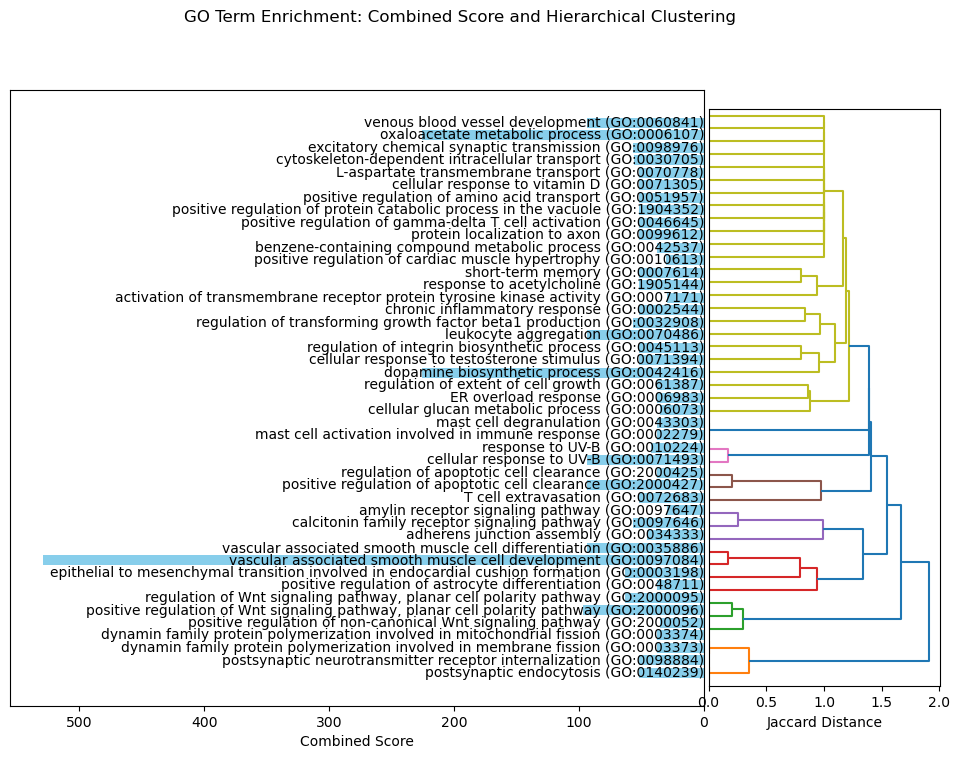

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import pdist


# Binary matrix for hierarchical clustering
all_genes = sorted(set.union(*top_terms['Genes']))
binary_matrix = pd.DataFrame(
    [[1 if gene in gene_set else 0 for gene in all_genes] for gene_set in top_terms['Genes']],
    columns=all_genes,
    index=top_terms['Term']
)

# Compute Jaccard distances and linkage for dendrogram
jaccard_distances = pdist(binary_matrix, metric="jaccard")
linkage_matrix = linkage(jaccard_distances, method='ward')

# Get the order of terms as they appear in the dendrogram
dendro_order = leaves_list(linkage_matrix)
ordered_terms = top_terms.iloc[dendro_order]

# Create figure with two subplots
fig, (ax_bar, ax_dendro) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [3, 1]})

# Plot the horizontal bar plot on the left with overlaid text, following the dendrogram order
y_positions = range(len(ordered_terms))  # Y positions for each bar
ax_bar.barh(y_positions, ordered_terms['Combined Score'], color=bar_colors)
ax_bar.set_yticks([])  # Remove y-ticks for clean appearance
ax_bar.set_xlabel('Combined Score')
ax_bar.invert_xaxis()

# Overlay GO term names on the bars in the sorted order
# Overlay GO term names on the bars in the sorted order
for i, (score, term) in enumerate(zip(ordered_terms['Combined Score'], ordered_terms['Term'])):
    ax_bar.text(0, i, term, ha='right', va='center', fontsize=10)  # Adjust -10 for text alignment



# Plot the dendrogram on the right, ensuring it aligns with the bar plot order
dendrogram(linkage_matrix, labels=None, orientation='right', ax=ax_dendro)
ax_dendro.set_yticks([])  # Remove y-ticks to avoid double labeling
ax_dendro.set_aspect(0.01111)
ax_dendro.set_xlabel("Jaccard Distance")

# Add titles and adjust layout
fig.suptitle("GO Term Enrichment: Combined Score and Hierarchical Clustering")
plt.subplots_adjust(wspace=0.01)
plt.show()



ENG,HEY2,HES1,NOTCH1,RAMP2,EFEMP2

## 2.4. Cneplot

/var/folders/m7/flh9t6s12jzgc695c07n5h9w0000gn/T/ipykernel_22855/4092647458.py:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/m7/flh9t6s12jzgc695c07n5h9w0000gn/T/ipykernel_22855/4092647458.py:80: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.



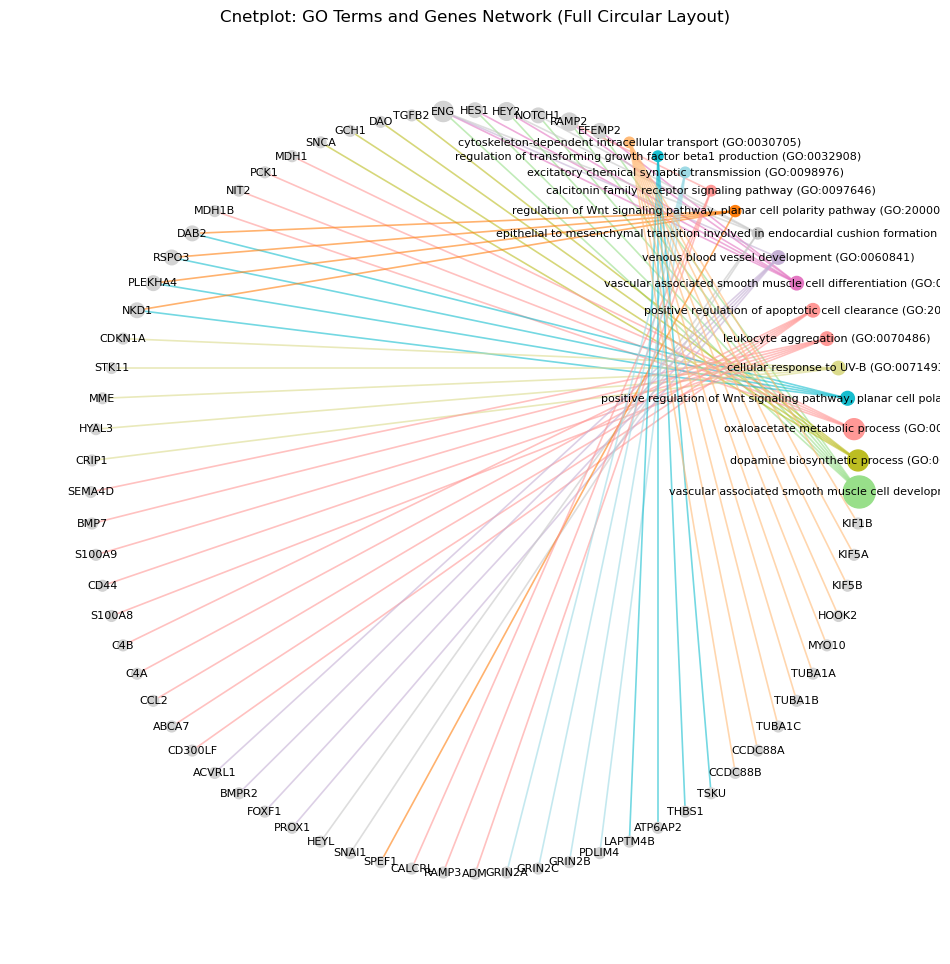

In [159]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import random

# Sample data setup (assuming 'top_terms' DataFrame is defined with columns: 'Term', 'Genes', and 'Combined Score')
# Each 'Term' is connected to multiple genes, separated by semicolons in the 'Genes' column.

# Step 1: Initialize the graph
G = nx.Graph()

# Step 2: Add GO terms and their associated genes as nodes, and connect them
for _, row in top_terms.iterrows():
    term = row['Term']  # GO term
    combined_score = row['Combined Score']
    genes = row['Genes'].split(';')  # Split genes by semicolon
    
    # Add GO term node with combined score as an attribute
    G.add_node(term, type='GO_term', combined_score=combined_score)
    
    for gene in genes:
        G.add_node(gene, type='gene')  # Add each gene as a node
        G.add_edge(term, gene)  # Connect the GO term to each gene

# Step 3: Define colors and sizes
# Get distinct colors for each GO term
colormap = plt.cm.get_cmap('tab20')
color_palette = [colormap(i) for i in range(colormap.N)]
#color_palette = list(mcolors.CSS4_COLORS.values())  # Use Tableau color palette for multiple distinct colors
go_term_colors = {term: random.choice(color_palette) for term in G if G.nodes[term]['type'] == 'GO_term'}

# Assign node colors and sizes
node_colors = []
node_sizes = []
edge_colors = []

for node in G:
    if G.nodes[node]['type'] == 'GO_term':
        color = go_term_colors[node]  # Color based on term
        node_colors.append(color)
        node_size =  G.nodes[node]['combined_score']  # Scale size by combined_score
        node_size = min(node_size, 3000)
        node_sizes.append(node_size)  # Scale size by combined_score
    else:
        degree = G.degree(node)  # Number of edges connected to the gene node
        node_size = 10 + 50 * degree  # Example scaling: base size + scaling factor * degree
        node_size = min(node_size, 300)  # Cap the size to prevent excessive overlap
        node_sizes.append(node_size)
        node_colors.append('lightgrey')  # Fixed color for genes
        G.nodes[node]['size'] = node_size

# Assign edge colors based on the GO term they are connected to
for edge in G.edges:
    term_node = edge[0] if G.nodes[edge[0]]['type'] == 'GO_term' else edge[1]
    edge_colors.append(go_term_colors[term_node])

# Step 4: Create a circular layout and ensure GO terms are clustered
# Separate GO terms and genes
go_terms = [node for node in G if G.nodes[node]['type'] == 'GO_term']
genes = [node for node in G if G.nodes[node]['type'] == 'gene']

# Arrange nodes in a circular layout with GO terms grouped together
pos = {}
angle_gap = 2 * np.pi / len(G)
# Arrange GO terms at the start of the circle
for i, term in enumerate(go_terms):
    angle = angle_gap * i
    pos[term] = (np.cos(angle), np.sin(angle))

# Follow with genes to complete the circle
for i, gene in enumerate(genes):
    angle = angle_gap * (i + len(go_terms))  # Continue angle from last GO term
    pos[gene] = (np.cos(angle), np.sin(angle))

# Step 5: Draw the network with the full circular layout
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.6, width=1.2)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Cnetplot: GO Terms and Genes Network (Full Circular Layout)")
plt.axis('off')  # Hide axes for a cleaner look
plt.show()


In [162]:
import matplotlib.colors as mcolors

# Assign node colors and sizes
node_colors = []
node_sizes = []
edge_colors = []

for node in G:
    if G.nodes[node]['type'] == 'GO_term':
        color = go_term_colors[node]  # Color based on term
        node_colors.append(color)
        # Adjusted scaling factor for GO term sizes to vary less
        node_size =  G.nodes[node]['combined_score']/2  # Reduced scaling factor
        node_size = min(node_size, 100)  # Cap the size to prevent excessively large nodes
        node_sizes.append(node_size)
        G.nodes[node]['size'] = node_size  # Assign size as node attribute for Gephi
    else:
        degree = G.degree(node)  # Number of edges connected to the gene node
        # Adjusted scaling factor for gene node sizes to vary less
        node_size = (10 + 10 * degree )  # Example scaling: base size + scaling factor * degree
        node_size = min(node_size, 150)  # Cap the size to prevent excessive overlap
        node_sizes.append(node_size)
        node_colors.append('lightgreen')  # Fixed color for genes
        G.nodes[node]['size'] = node_size  # Assign size as node attribute for Gephi

# Assign 'color' attribute to each node in hexadecimal format
for node in G.nodes():
    if G.nodes[node]['type'] == 'GO_term':
        color = go_term_colors[node]
    else:
        color = 'lightgreen'
    hex_color = mcolors.to_hex(color)  # Convert color to hex
    G.nodes[node]['color'] = hex_color  # Assign to node attribute

# Prepare node sizes (now safely accessible as attributes)
node_sizes = [G.nodes[node]['size'] for node in G.nodes()]

# Prepare edge colors in hexadecimal format and assign as edge attributes
edge_colors_hex = []
for edge in G.edges():
    # Determine which node is the GO term
    term_node = edge[0] if G.nodes[edge[0]]['type'] == 'GO_term' else edge[1]
    color = go_term_colors[term_node]
    hex_color = mcolors.to_hex(color)  # Convert to hex
    G.edges[edge]['color'] = hex_color  # Assign to edge attribute for Gephi
    edge_colors_hex.append(hex_color)

# Export the graph to GraphML format for Gephi
nx.write_graphml(G, "cnet_go_terms_genes_network.graphml")
print("Graph exported to 'cnet_go_terms_genes_network.graphml'")


Graph exported to 'cnet_go_terms_genes_network.graphml'


## 2.5. Sunburst

In [25]:
top_terms.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,vascular associated smooth muscle cell develop...,6/7,0.000013,0.061774,0,0,47.102258,528.997601,EFEMP2;RAMP2;NOTCH1;HEY2;HES1;ENG
8,GO_Biological_Process_2021,dopamine biosynthetic process (GO:0042416),4/5,0.000746,0.230948,0,0,31.373728,225.902842,TGFB2;DAO;GCH1;SNCA
9,GO_Biological_Process_2021,oxaloacetate metabolic process (GO:0006107),4/5,0.000746,0.230948,0,0,31.373728,225.902842,MDH1;PCK1;NIT2;MDH1B
22,GO_Biological_Process_2021,"positive regulation of Wnt signaling pathway, ...",4/6,0.002037,0.411961,0,0,15.685980,97.193002,DAB2;RSPO3;PLEKHA4;NKD1
10,GO_Biological_Process_2021,cellular response to UV-B (GO:0071493),5/8,0.000773,0.230948,0,0,13.076696,93.697643,CDKN1A;STK11;MME;HYAL3;CRIP1


In [28]:
import pandas as pd
import plotly.express as px

# Sample data structure based on provided DataFrame
# Assuming `top_terms` DataFrame has columns as described

# Prepare the DataFrame
top_terms['GO_ID'] = top_terms['Term'].str.extract(r'\((GO:\d+)\)')[0]  # Extract GO ID if available
top_terms['Term_Simplified'] = top_terms['Term'].str.split('(').str[0].str.strip()  # Simplify term name

# Generate the Sunburst plot
fig = px.sunburst(
    top_terms,
    path=['Gene_set', 'Term_Simplified', 'GO_ID'],  # Define the hierarchy of layers
    values='Combined Score',  # Use Combined Score for size (or 'P-value' if preferred)
    color='Adjusted P-value',  # Color by Adjusted P-value
    color_continuous_scale='RdYlBu_r',  # Color scale (red for low p-values to blue for high)
    title="GO Enrichment Sunburst Plot"
)

# Update layout for better readability
fig.update_layout(margin=dict(t=30, l=0, r=0, b=0))

# Show the plot
fig.show()


In [32]:
# Step 3: Assign clusters based on the linkage matrix
# Define a threshold for clustering; adjust as needed
top_terms['Cluster'] = fcluster(linkage_matrix, t=3, criterion='maxclust')  # Adjust `t` for desired cluster size
top_terms['Cluster'] = 'Cluster_' + top_terms['Cluster'].astype(str)  # Label clusters for readability
top_terms['Term_Simplified'] = top_terms['Term'].str.split('(').str[0].str.strip()  # Clean up term names

# Step 4: Create the Sunburst plot with clustering as hierarchy
fig = px.sunburst(
    top_terms,
    path=['Cluster', 'Gene_set', 'Term_Simplified'],  # Hierarchy: Cluster > Gene Set > Term
    values='Combined Score',                           # Size each section by Combined Score
    color='Adjusted P-value',                          # Color by Adjusted P-value
    color_continuous_scale='Viridis',
    title="Clustered GO Enrichment Sunburst Plot"
)

# Adjust layout for readability
fig.update_layout(margin=dict(t=40, l=0, r=0, b=0))
fig.update_coloraxes(colorbar_title="Adj. P-value", colorbar_tickformat=".2e")

# Display the plot
fig.show()


## 2.6. Heatmap 

## 2.7. Circular dendrogram 

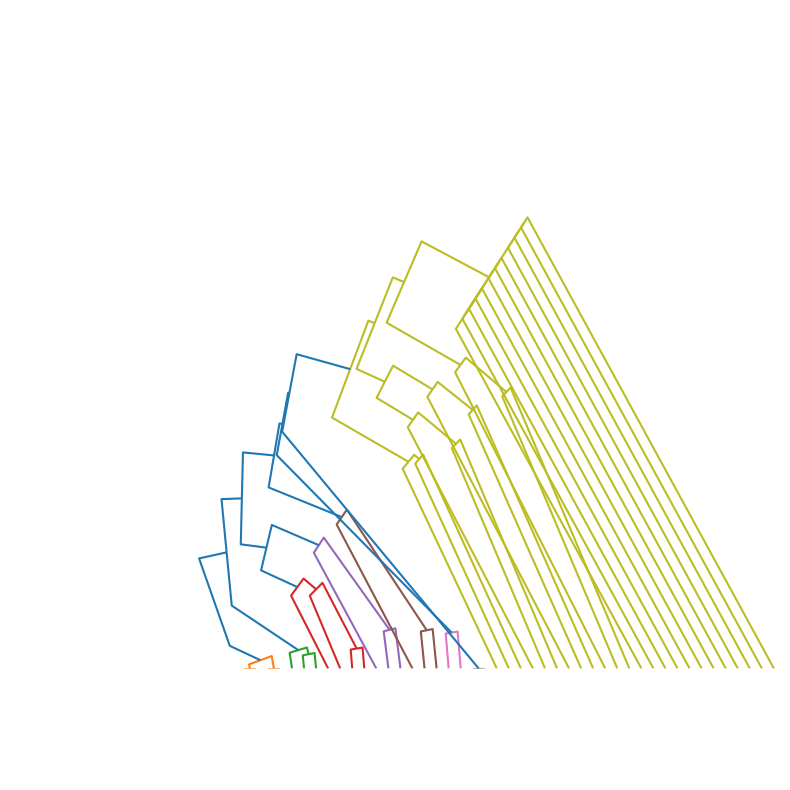

In [34]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Assuming `top_terms` DataFrame has 'Term' and 'Genes' columns
# Prepare binary matrix based on gene presence in each GO term
top_terms['Gene_List'] = top_terms['Genes'].str.split(';')
all_genes = sorted(set(gene for genes in top_terms['Gene_List'] for gene in genes))

# Create binary matrix for Jaccard distances
binary_matrix = pd.DataFrame(
    [[1 if gene in gene_list else 0 for gene in all_genes] for gene_list in top_terms['Gene_List']],
    columns=all_genes,
    index=top_terms['Term']
)

# Compute Jaccard distances and linkage matrix
jaccard_distances = pdist(binary_matrix, metric="jaccard")
linkage_matrix = linkage(jaccard_distances, method='ward')

# Create a circular dendrogram
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Plot the dendrogram in a circular layout
dendrogram(
    linkage_matrix,
    labels=top_terms['Term'].values,
    leaf_rotation=0,           # Rotate labels so they face outward
    leaf_font_size=8,
    orientation='right'         # Orientation required to position leaves on circumference
)

# Remove axis for a cleaner look
plt.axis('off')
plt.show()



In [37]:
import pandas as pd
import networkx as nx
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def export_dendrogram_network(dataframe, output_type="gephi", save_to_file=True):
    """
    Exports the dendrogram data to either Gephi or Cytoscape format with node attributes.
    
    Parameters:
    - dataframe (pd.DataFrame): DataFrame with hierarchical clustering data, must include 'Term' and 'Genes' columns.
    - output_type (str): 'gephi' for GraphML export or 'cytoscape' for CSV export.
    - save_to_file (bool): If True, saves files to disk; otherwise, returns NetworkX Graph object and DataFrame for nodes.
    
    Returns:
    - Graph (nx.Graph): NetworkX graph object (if save_to_file is False).
    - node_attributes (pd.DataFrame): DataFrame with node attributes (if save_to_file is False).
    """
    
    # Step 1: Prepare binary matrix of gene presence for Jaccard distances
    dataframe['Gene_List'] = dataframe['Genes'].str.split(';')
    all_genes = sorted(set(gene for genes in dataframe['Gene_List'] for gene in genes))

    # Create binary matrix for Jaccard distances
    binary_matrix = pd.DataFrame(
        [[1 if gene in gene_list else 0 for gene in all_genes] for gene_list in dataframe['Gene_List']],
        columns=all_genes,
        index=dataframe['Term']
    )

    # Step 2: Compute Jaccard distances and linkage
    jaccard_distances = pdist(binary_matrix, metric="jaccard")
    linkage_matrix = linkage(jaccard_distances, method='ward')

    # Initialize an empty NetworkX graph
    G = nx.Graph()

    # Step 3: Add terms as initial nodes with attributes
    for idx, term in enumerate(binary_matrix.index):
        G.add_node(idx, label=dataframe['Term'].iloc[idx], combined_score=dataframe['Combined Score'].iloc[idx])

    # Convert linkage matrix to edges
    node_counter = len(binary_matrix)  # Start from the next node after leaves

    for i, (node1, node2, dist, _) in enumerate(linkage_matrix):
        node1, node2 = int(node1), int(node2)

        # Add edges for clustering hierarchy
        G.add_edge(node_counter, node1, weight=dist)
        G.add_edge(node_counter, node2, weight=dist)

        # Add the new internal node with cluster label
        G.add_node(node_counter, label=f"Cluster_{node_counter}")
        node_counter += 1

    # Step 4: Export based on output_type
    if output_type == "gephi":
        if save_to_file:
            # Save as GraphML for Gephi
            nx.write_graphml(G, "dendrogram_graph.graphml")
            print("GraphML exported to 'dendrogram_graph.graphml'")
        else:
            return G

    elif output_type == "cytoscape":
        # Generate edge and node data for Cytoscape with attributes
        edges = nx.to_pandas_edgelist(G)
        nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').reset_index()
        nodes.columns = ['Node', 'Label', 'Combined Score']
        
        if save_to_file:
            edges.to_csv("cytoscape_edges.csv", index=False)
            nodes.to_csv("cytoscape_nodes.csv", index=False)
            print("Cytoscape data exported to 'cytoscape_edges.csv' and 'cytoscape_nodes.csv'")
        else:
            return G, nodes


In [38]:
export_dendrogram_network(top_terms, output_type="gephi", save_to_file=True)

GraphML exported to 'dendrogram_graph.graphml'
